In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# Set Matplotlib style for professional, academic-quality plots
plt.rcParams.update({'font.size': 14})

In [2]:
def plot_metrics_over_seeds(log_dir, exp_name, model_name, metrics, save_dir=None):
    """
    Plot specified metrics over epochs with mean and 95% CI across seeds.
    
    Parameters:
    - log_dir (str): Root directory containing experiment outputs (e.g., './outputs').
    - exp_name (str): Experiment name (e.g., 'dev').
    - model_name (str): Model name (e.g., 'vae').
    - metrics (list): List of metric names to plot (e.g., ['test_kl_losses', 'train_recon_losses']).
    - save_dir (str, optional): Directory to save plots (e.g., './plots'). If None, plots are shown only.
    """
    # Find all stats.csv files
    pattern = os.path.join(log_dir, f"run_{exp_name}_{model_name}", "seed_*_*", "stats.csv")
    csv_files = glob.glob(pattern)
    if not csv_files:
        print(f"No stats.csv files found in {pattern}")
        return

    # Load all CSVs into a single DataFrame with a 'seed' column
    all_dfs = []
    for file_path in csv_files:
        folder_name = os.path.basename(os.path.dirname(file_path))
        seed = int(folder_name.split('_')[1])  # Extract seed from 'seed_{seed}_{timestamp}'
        df = pd.read_csv(file_path)
        df['seed'] = seed
        all_dfs.append(df)
    combined_df = pd.concat(all_dfs, ignore_index=True)

    # Ensure epochs are present and sorted
    if 'epochs' not in combined_df.columns:
        print("Error: 'epochs' column not found in the CSV files.")
        return

    # Plot each metric
    for metric in metrics:
        if metric not in combined_df.columns:
            print(f"Warning: Metric '{metric}' not found in the data. Skipping.")
            continue

        # Group by epochs and compute statistics
        grouped = combined_df.groupby('epochs')[metric].agg(['mean', 'std', 'count']).sort_index()
        epochs = grouped.index
        mean = grouped['mean']
        std = grouped['std']
        n = grouped['count']

        # Compute 95% confidence interval
        se = std / np.sqrt(n)  # Standard error
        ci = se * stats.t.ppf(0.975, df=n-1)  # 95% CI using t-distribution

        # Create the plot
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, mean, label='Mean', color='blue', linewidth=2)
        if n.iloc[0] > 1:  # Only add CI if more than one seed
            plt.fill_between(epochs, mean - ci, mean + ci, color='blue', alpha=0.2, label='95% CI')
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel(metric.replace('_', ' ').title(), fontsize=14)  # Nicer y-axis label
        plt.title(f'{metric.replace("_", " ").title()} over Epochs', fontsize=16, pad=10)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Save the plot if save_dir is provided
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f'{metric}.png'), dpi=300, bbox_inches='tight')
        plt.show()

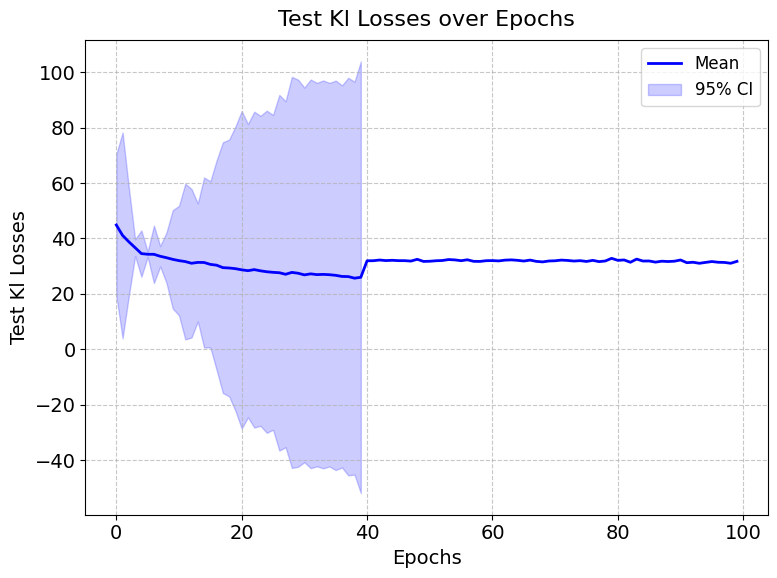

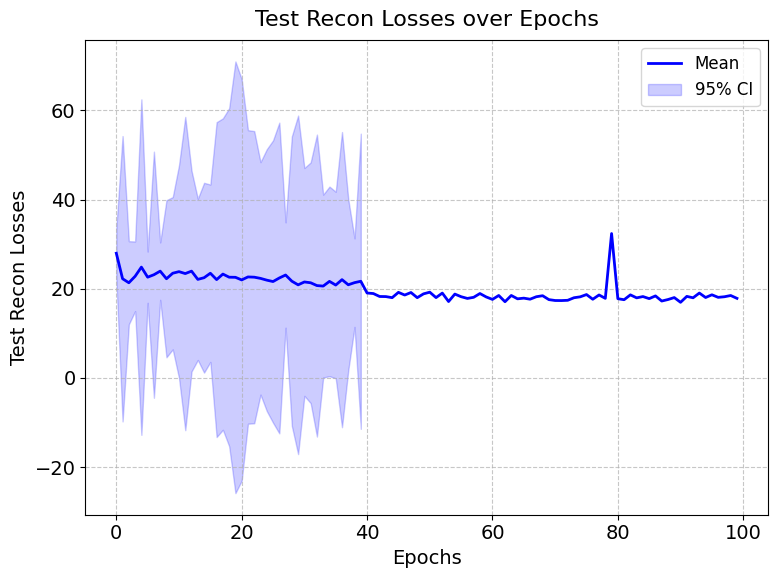

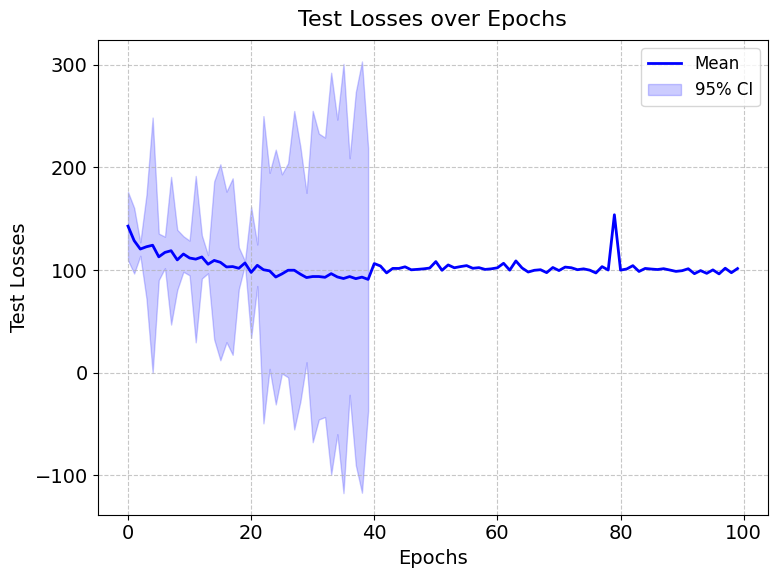

In [3]:
plot_metrics_over_seeds(
    log_dir="../outputs",
    exp_name="dev",
    model_name="maga",
    metrics=["test_kl_losses", "test_recon_losses", "test_losses"],
    save_dir="./plots"  # Optional
)